In [1]:
from sklearn.model_selection import train_test_split
from sktime.classification.shapelet_based import MrSEQLClassifier

ModuleNotFoundError: No module named 'sktime'

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
from library import lib_aws
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# Opttions
pd.set_option('display.max_rows', 500)
mpl.rcParams['figure.figsize'] = (25,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# basic ml
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import Data and Failures

Includes basic data-cleanup:
- Reducing Failure classes
- Merging Failures with main data
- Creating a column of forecasting zones

In [5]:
%%time
# Querying the entire failure info
query_failures = """
SELECT *
FROM
    analysis.failure_info
ORDER BY "NodeID";
"""

with lib_aws.PostgresRDS(db='oasis-prod', verbose=1) as engine:
    failures = pd.read_sql(query_failures, engine, parse_dates=['Failure Start Date', 'Failure End Date'])

well_list = failures.NodeID.unique().tolist()  # List of wells to use for querying the features and model training
failures.head()

Connected to oasis-prod DataBase
Connection Closed
Wall time: 5.96 s


,NodeID,Failure Start Date,Failure End Date,Failures
0,Aagvik 1-35H,2019-10-29 10:43:24,2020-01-05 11:27:10,Tubing - Body
1,Acklins 6092 12-18H,2019-12-22 13:03:58,2020-01-05 04:47:00,Polish Rod
2,Alder 6092 43-8H,2020-03-05 13:28:53,2020-03-14 09:01:01,Pump - Stuck Pump
3,Alder 6092 43-8H,2019-12-20 06:53:56,2020-01-08 08:56:36,Pump - Traveling Valve
4,Andersmadson 5201 42-24 3B,2019-08-12 14:20:29,2019-08-16 18:00:57,Pump - Plunger


In [6]:
# Reducing Failure classes
failures.loc[failures.Failures.str.contains('Tubing'), 'Failures'] = 'Tubing'
failures.loc[failures.Failures.str.contains('Pump'), 'Failures'] = 'Pump'
failures.loc[failures.Failures.str.contains('Rod'), 'Failures'] = 'Rod'
failures.loc[failures.Failures.str.contains('BHA'), 'Failures'] = 'BHA'
failures.sample(5)

,NodeID,Failure Start Date,Failure End Date,Failures
263,Shaw 6092 11-23 2T,2019-09-27 12:03:13,2019-10-11 07:23:12,Pump
201,Lundeen 4-26H,2019-07-29 12:32:23,2019-08-13 09:11:02,BHA
72,Donna 12X-35H,2019-12-06 20:47:00,2019-12-16 06:58:13,Rod
3,Alder 6092 43-8H,2019-12-20 06:53:56,2020-01-08 08:56:36,Pump
219,Montague 5501 13-3 2T,2020-01-07 07:28:06,2020-01-24 09:25:09,Rod


In [7]:
%%time
# for well_list use only those wells which have been labeled
data_query = """
SELECT
    "NodeID",
    "Date",
    "PPRL",
    "MPRL",
    "FluidLoadonPump",
    "PumpIntakePressure"
FROM xspoc.xdiag
WHERE "NodeID" in {}
ORDER BY "NodeID","Date"
""".format(tuple(well_list))

with lib_aws.PostgresRDS(db='oasis-prod') as engine:
    data = pd.read_sql(data_query, engine, parse_dates=['Date'])
    
well_list_features = data.NodeID.unique()
data.head()

Wall time: 1min 12s


,NodeID,Date,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure
0,Aagvik 1-35H,2019-06-21 15:58:34,27639.0,16811.0,3280.0,NaN
1,Aagvik 1-35H,2019-06-21 16:25:36,27457.0,16752.0,3241.0,NaN
2,Aagvik 1-35H,2019-06-21 18:25:16,27448.0,16594.0,3330.0,NaN
3,Aagvik 1-35H,2019-06-21 18:28:10,27424.0,16595.0,3327.0,NaN
4,Aagvik 1-35H,2019-06-21 20:25:01,27662.0,16711.0,3341.0,NaN


In [ ]:
"""
Checking the Distribution of Data
"""
well = 'Aagvik 1-35H'

x = data[data.NodeID == well].Date[1:]
y = data[data.NodeID == well].Date.diff()[1:]
y = y/pd.Timedelta('1hour')

plt.plot(x,y, 'r-')
np.mean(y)  

In [8]:
"""
Combining Failure data
"""
def fill_null(dataframe, chk_col='PPRL', well_col='NodeID', time_col='Date'):
    """
    This function will fill in Null Values on those dates where no datapoints are present
    Helps Show failures where no data was present
    Will have to take this into account when running analysis 
    """
    data_temp = dataframe.copy()
    # Set time col as index if it is not
    if time_col in data_temp.columns:
        data_temp.set_index(time_col, inplace=True)
    
    data_gp = data_temp.groupby(well_col).resample('1D').max()  # Groupby wellname and resample to Day freq
    data_gp.drop(columns=[well_col], inplace=True)  # Drop these columns as they are present in the index
    data_gp.reset_index(inplace=True)  # Get Back WellCol from
    data_null = data_gp[data_gp.loc[:, chk_col].isnull()]  # Get all null values, which need to be added to the main data file
    data_null.reset_index(inplace=True, drop=True)
    data_temp.reset_index(inplace=True)  # get timestamp back in the column for concating
    data_full = pd.concat([data_temp, data_null], axis=0, ignore_index=True)  # concat null and og files
    data_full.sort_values(by=[well_col, time_col], inplace=True)
    data_full.drop_duplicates(subset=[well_col, time_col], inplace=True)
    data_full.reset_index(drop=True, inplace=True)
    
    return data_full


def failure_merge(dataframe, failure_dataframe, transfer_cols):
    """
    Merges the failures info
    :param dataframe: Dataframe to which info is being transferred to. (Should have columns "NodeID" and "Date")
    :param failure_dataframe: Failure info data (Should have columns "NodeID", "Start Date" and "End Data")
    :param cols: Columns which need to be transferred
    """
    merged = dataframe.copy()  
    for col in transfer_cols:
        merged[col] = 'Normal'  # for now putting everything as normal (even NAN's)
        
    for i in failure_dataframe.index:
        well = failure_dataframe.loc[i, 'NodeID']
        t_start = failure_dataframe.loc[i, 'Failure Start Date']
        t_end = failure_dataframe.loc[i, 'Failure End Date'] + pd.Timedelta('1 day')  # As we have day based frequency (the times in a day are considered as 00:00:00)
        bool_ = (merged.NodeID == well) & (merged.Date >= t_start) & (merged.Date <= t_end)  # Boolean mask for main data
        if len(transfer_cols) == 1:  # If only single transfer col
            merged.loc[bool_, transfer_cols] = failure_dataframe.loc[i, transfer_cols].values[0]
        else:  # when multiple cols are transferred
            merged.loc[bool_, transfer_cols] = failure_dataframe.loc[i, transfer_cols].values
        
    return merged


In [9]:
def create_forecasting_zones(df, fail_col, forecasting_zone_dict):
    """
    Using the forecasting_zone_dict, create forecasting labels.
    Will give a series of new labels
    :param df: The dataframe to extract it from
    :param fail_col: Failure column to use from the dataframe
    :param forecasting_zone_dict: A dict with timedeltas for each type of Failure in fail_col
    :return Will return a Series or an Array of these Prediction Zones
    """
    
    test_data = df[['NodeID', 'Date', fail_col]].copy()
    fail_zones = test_data[fail_col]  # fail_zones will be initialized as a copy of the fail col
    
    # Getting start of predictions from fail col
    fail_dates = test_data[test_data[fail_col] != 'Normal']  # everthing other than normal is considered as a prediction
    fail_start = fail_dates[fail_dates.Date.diff().abs().fillna(pd.Timedelta('10D')) > pd.Timedelta('1d 12H')]
    fail_start.reset_index(inplace=True, drop=True)
    
    # Adding zones by iterating over each prediction start date
    for i in fail_start.index:
        temp_well = fail_start.loc[i, 'NodeID']  # well name
        zone_end_date = fail_start.loc[i, 'Date']  # prediction start date
        fail = fail_start.loc[i, fail_col]  # actual prediction class
        zone_delta = pd.Timedelta(forecasting_zone_dict[fail])  # delta to subtract from the dictionary
        zone_start_date = zone_end_date - zone_delta

        bool_ = (test_data.NodeID == temp_well) & (test_data.Date < zone_end_date) & (test_data.Date >= zone_start_date)
        fail_zones[bool_] = 'fz_' + fail
        
    return fail_zones

In [10]:
# Transferring failures
data.head()
transfer_cols = ['Failures']
data_with_failures = failure_merge(data, failures, transfer_cols)

In [11]:
# Getting forecasting zones
fail_window = '15 days'  # we want to forecast failures 7 days in advance, so we assume we start seeing trends in these zones
fail_labels = data_with_failures.Failures.unique().tolist()
fail_labels.remove('Normal')
failure_zone_dict = {x: fail_window for x in fail_labels}

# Create pred windows
# Note:  The output of the fucntion will be a pandas Series
data_with_failures['Label'] = create_forecasting_zones(df=data_with_failures, 
                                                     fail_col='Failures', 
                                                     forecasting_zone_dict=failure_zone_dict)

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
# changing acturl labels to dropped in column where we show failures
data_with_failures.loc[data_with_failures.Label.isin(fail_labels), 'Label'] = 'Drop'
data_with_failures.Label = data_with_failures.Label.str.replace('fz_', '').str.strip()  # keeping the name of the zone classes the same as the original one

Normal    813193
Pump       12251
Rod         9627
Tubing      9182
Drop        8839
BHA          575
Name: Label, dtype: int64

In [56]:
final_label_dt = pd.Timestamp('7/1/2020')
data_with_failures = data_with_failures[data_with_failures.Date <= final_label_dt]
data_with_failures.reset_index(drop=True, inplace=True)

In [57]:
data_with_failures.Label.value_counts()

Normal    567828
Pump       12251
Rod         9627
Tubing      8795
Drop        8507
BHA          575
Name: Label, dtype: int64

# Segmention 

First step in preprocessing is spliting the timeseries into segments.

Some conditions for these segments:

- Segment size will be specified using a time-delta and min_data_points within it.
    - The main reason for doing this is to handle irregular sampling intervals
    - Handle missing values

- Data within these segements will have equivalent data sampling. 
    - We could howver play around with this.
    - As we want to avoid resampling the data, we could have a variable which controls the minimum number of data points within these segments.
    - This will lead to unequal data points in the segments. Will this cause issues?

- A paramter will control the percentage of overlap between consequtive segments.

- Handling Labels:
    - In a segment even if one datapoint is labelled as a failure that segment is labelled as a failure
    - In a failure seg, if the last data-point is 'Normal' that will be dropped
    - segemnts with 'Drop' in the label col will be dropped. 
    - This will happen even if the segment has a single drop label. 
    - While marking drop in the labels take this into account
    
    
    
References:

[Data Containers sktime](https://github.com/alan-turing-institute/sktime/blob/1e472eaea8e42330e2a4581559b9c981ebf74c87/sktime/utils/data_container.py)

In [64]:
def create_segments_srp(dataframe, seg_size, min_data_points, overlap, feature_col, label_col):
    """
    Ceate a 3d array of segments (instance, segment-length, features)
    Normalize the data before
    Works only for a single well
    
    :param dataframe: DataFrame with index as timestamp and normalized features as columns
    :param seg_size: Timedelta for segment
    :param min_data_points: Minimum datapoints within the seg_size, this will be the size of the segments
    :param overlap: Fraction which says how much % of consecutive segments should be different
    :param feature_col: Which Features to use for creating segments (works for multivariate)
    :param label_col: Column name to use for labelling the segments
    
    Some Assumptions:
    Adding Labels:
    - In a segment even if one datapoint is labelled as a failure that segment is labelled as a failure
    - In a failure seg, if the last data-point is 'Normal' that will be dropped
    - Segemnts with 'Drop' in the label col will be dropped. 
    - This will happen even if the segment has a single drop label. 
    - While marking drop in the labels take this into account
    """
    valid_seg = []  # initialize empty valid segments array
    valid_seg_time = []  # initialize empty timestamp 
    valid_seg_labels = []  # Initialize empty label segments
    
    t0_old = dataframe.index[0] - (seg_size * overlap) # intialize the t0_old so overlap condition wont be triggered in the first iteration
    seg_len = []
    
    for t0 in dataframe.index:
        # Overlap handling
        # go to next iteration if t0 - t0_old (current iteration time - the previous one) is less than how much timedelta in overlap
        # TODO: may cause issues when frequency is not constant--need to check
        if (t0 - t0_old) < (seg_size * overlap):  
            continue
            
        tn = t0 + seg_size  # index + seq+size
        seg = dataframe.loc[t0:tn, feature_col].dropna()  # get the seg and drop nan values
        labels = dataframe.loc[t0:tn, label_col].values  # Get list of labels
        
        # check if segment contains minimum data points only then it can be a valid segment
        # this will also drop the segments in the end
        if len(seg) >= min_data_points:
            
            # Label Handling
            labels = labels[0:min_data_points]
            # Skip those segments which have 'Drop' in any datapoints
            if 'Drop' in labels: 
#                 print('Dropped')
                continue 
            # if all labels are normal seg_label will be 'Normal'
            elif all(x == 'Normal' for x in labels):  
                seg_label = 'Normal'
            # contains a label other than 'Normal'
            else:
                seg_label = [x for x in labels if x != 'Normal']
                seg_label = np.unique(seg_label)[0]
            
            # If failure seg and last val is 'Normal' drop the segment
            if (seg_label != 'Normal') & (labels[-1] == 'Normal'):
                continue
            
            vals = seg.iloc[0:min_data_points].values  # to keep size of segments equivalent only the min_data_points are taken
#             print(f'Length of Segment: {len(seg)}\tLength of Vals {len(vals)}\tWith Label {seg_label}')
            valid_seg.append(vals)  # append the valid segments to the valid seg array
            valid_seg_time.append(seg.index[0:min_data_points].values)
            valid_seg_labels.append(seg_label)
            
        t0_old = t0  # will be used for overlap handling
        seg_len.append(len(seg))
        
        
    valid_seg = np.array(valid_seg)
    valid_seg_time = np.array(valid_seg_time)
    print(f'Avg Valid Segment Lenght : {sum(seg_len)/len(seg_len)}')
    
    return valid_seg, valid_seg_labels, valid_seg_time

In [14]:
def nested_dataframe_from_3d_array(X):
    """
    Convert numpy array with shape (n_instance, n_timepoints, n_features)
    into a pandas DataFrame (with timeseries as pandas Series in cells)
    :param X: NumPy ndarray, input
    :returns pandas DataFrame
    """
    dataframe = pd.DataFrame()
    n_instances = X.shape[0]
    n_variables = X.shape[2]
    
    for variable in range(n_variables):
        dataframe['var_' + str(variable)] = [pd.Series(X[instance, :, variable]) for instance in range(n_instances)]
    
    return dataframe


In [65]:
"""
Creating Segments for single well
"""

well = 'Berquist 34-27H'

df = data_with_failures[data_with_failures.NodeID == well].copy()
display(df.isnull().sum(axis=0)/len(df) * 100)
df = df.drop(columns='NodeID').set_index('Date').dropna()  # only drop nulls for features you wanna use going ahead
df.sort_index(inplace=True)
df.head()

NodeID                0.000000
Date                  0.000000
PPRL                  6.255405
MPRL                  6.255405
FluidLoadonPump       6.255405
PumpIntakePressure    9.397521
Failures              0.000000
Label                 0.000000
dtype: float64

,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,Failures,Label
Date,,,,,,
2019-05-27 23:26:12,30766.0,15243.0,5560.0,2403.0,Normal,Normal
2019-05-28 01:40:16,28470.0,17875.0,5100.0,2656.0,Normal,Normal
2019-05-28 03:22:50,27978.0,18668.0,4486.0,2911.0,Normal,Normal
2019-05-28 05:24:15,30747.0,14992.0,4679.0,2831.0,Normal,Normal
2019-05-28 07:27:07,28753.0,17182.0,4528.0,2894.0,Normal,Normal


In [66]:
sc = MinMaxScaler()
fails= df.pop('Failures')
labels = df.pop('Label')
print(pd.DataFrame(labels.value_counts()))
df = pd.DataFrame(data=sc.fit_transform(df), index=df.index, columns=df.columns)
df = pd.concat([df, labels], axis=1)
df.head()

        Label
Normal   2810
Tubing    312
Drop       21


,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,Label
Date,,,,,
2019-05-27 23:26:12,0.569111,0.071673,0.515244,0.963095,Normal
2019-05-28 01:40:16,0.351295,0.463048,0.472616,0.971773,Normal
2019-05-28 03:22:50,0.304620,0.580967,0.415717,0.980519,Normal
2019-05-28 05:24:15,0.567309,0.034349,0.433602,0.977775,Normal
2019-05-28 07:27:07,0.378142,0.360000,0.419609,0.979936,Normal


In [67]:
segment1, label1, times1 = create_segments_srp(df, 
                                               seg_size=pd.Timedelta('3 day'), 
                                               min_data_points=30, 
                                               overlap=0.25,
                                               feature_col=['PPRL','MPRL', 'FluidLoadonPump', 'PumpIntakePressure'],
                                               label_col = 'Label')
label1 = pd.Series(label1)  # for ease of info extraction

Avg Valid Segment Lenght : 30.1994459833795


In [63]:
print(label1.value_counts())
# label1[label1 == 'Tubing']

Normal    162
Tubing     22
dtype: int64


Segment Label: Tubing


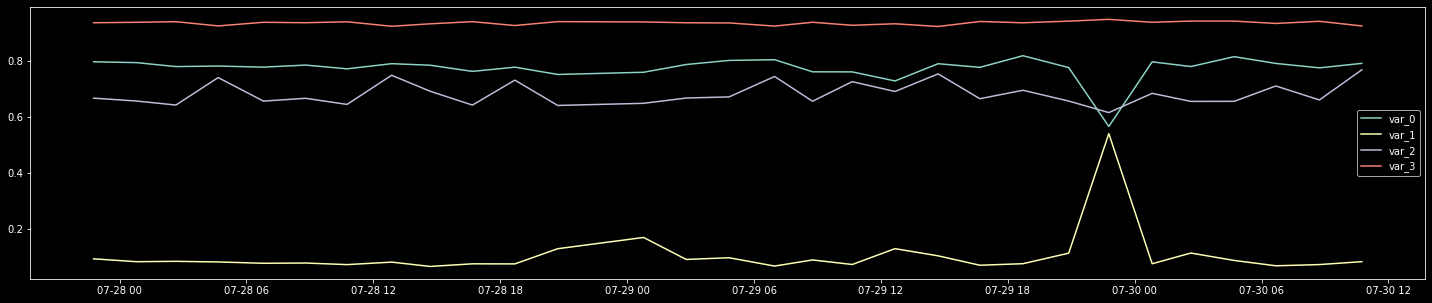

In [62]:
# plotting
i = 69

x1 = segment1[i,:,0]
x2 = segment1[i,:,1]
x3 = segment1[i,:,2]
x4 = segment1[i,:,3]

t = times1[i]

print(f'Segment Label: {label1.iloc[i]}')

for f in range(segment1.shape[2]):
    plt.plot(t,segment1[i,:,f], label='var_'+ str(f))
plt.legend()    
plt.show()

In [68]:
# Converting segments to pandas df
sample_df = nested_dataframe_from_3d_array(segment1)
sample_df.head()

,var_0,var_1,var_2,var_3
0,0 0.569111 1 0.351295 2 0.304620 3...,0 0.071673 1 0.463048 2 0.580967 3...,0 0.515244 1 0.472616 2 0.415717 3...,0 0.963095 1 0.971773 2 0.980519 3...
1,0 0.837776 1 0.726876 2 0.868039 3...,0 0.055316 1 0.410706 2 0.034944 3...,0 0.772588 1 0.690946 2 0.804189 3...,0 0.925607 1 0.938195 2 0.920771 3...
2,0 0.775828 1 0.780951 2 0.813016 3...,0 0.032416 1 0.035242 2 0.038513 3...,0 0.712168 1 0.805949 2 0.697526 3...,0 0.940595 1 0.926156 2 0.942825 3...
3,0 0.799734 1 0.746039 2 0.791576 3...,0 0.066022 1 0.009814 2 0.031078 3...,0 0.810120 1 0.742007 2 0.715226 3...,0 0.913225 1 0.923686 2 0.927802 3...
4,0 0.847358 1 0.834930 2 0.608766 3...,0 0.043420 1 0.054870 2 0.470632 3...,0 0.747289 1 0.699194 2 0.727180 3...,0 0.922863 1 0.930272 2 0.925984 3...


In [76]:
"""
Segmentation for another well
"""
well = 'Otis 2658 43-23H'

df = data_with_failures[data_with_failures.NodeID == well].copy()
display(df.isnull().sum(axis=0)/len(df) * 100)
df = df.drop(columns='NodeID').set_index('Date').dropna()  # only drop nulls for features you wanna use going ahead
df.sort_index(inplace=True)
df.head()

NodeID                 0.000000
Date                   0.000000
PPRL                   9.877913
MPRL                   9.877913
FluidLoadonPump        9.877913
PumpIntakePressure    71.439142
Failures               0.000000
Label                  0.000000
dtype: float64

,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,Failures,Label
Date,,,,,,
2019-06-05 18:00:29,29321.0,16239.0,4960.0,1362.0,Normal,Normal
2019-06-15 00:10:51,29780.0,16618.0,5147.0,1256.0,Normal,Normal
2019-06-22 08:24:05,29087.0,16764.0,5053.0,1308.0,Normal,Normal
2019-06-25 14:29:14,29623.0,16534.0,5083.0,1286.0,Normal,Normal
2019-06-25 18:27:55,29655.0,16411.0,5193.0,1223.0,Normal,Normal


In [77]:
sc = MinMaxScaler()

fails= df.pop('Failures')
labels = df.pop('Label')
print(pd.DataFrame(labels.value_counts()))

df = pd.DataFrame(data=sc.fit_transform(df), index=df.index, columns=df.columns)
df = pd.concat([df, labels], axis=1)
df.head()

        Label
Normal    742
Pump       17
Drop       13


,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,Label
Date,,,,,
2019-06-05 18:00:29,0.236091,0.331705,0.261739,0.596282,Normal
2019-06-15 00:10:51,0.310981,0.434582,0.290064,0.549358,Normal
2019-06-22 08:24:05,0.197912,0.474213,0.275826,0.572377,Normal
2019-06-25 14:29:14,0.285365,0.411781,0.280370,0.562638,Normal
2019-06-25 18:27:55,0.290586,0.378393,0.297031,0.534750,Normal


In [82]:
segment2, label2, times2 = create_segments_srp(df, 
                                               seg_size=pd.Timedelta('3 days'), 
                                               min_data_points=30, 
                                               overlap=0.25,
                                               feature_col=['PPRL','MPRL', 'FluidLoadonPump', 'PumpIntakePressure'],
                                               label_col = 'Label')

Avg Valid Segment Lenght : 11.545893719806763


In [86]:
len(segment2)

0

In [79]:
# Converting segments to pandas df
sample_df2 = nested_dataframe_from_3d_array(segment2)
sample_df2.head()

,var_0,var_1,var_2,var_3
0,0 0.338391 1 0.406265 2 0.401860 3...,0 0.607220 1 0.476656 2 0.620250 3...,0 0.386852 1 0.523478 2 0.487277 3...,0 0.355024 1 0.129261 2 0.189022 3...
1,0 0.438571 1 0.446402 2 0.433513 3...,0 0.501900 1 0.555375 2 0.602606 3...,0 0.480763 1 0.460467 2 0.463647 3...,0 0.200089 1 0.233732 2 0.228420 3...
2,0 0.442323 1 0.448360 2 0.423234 3...,0 0.409881 1 0.500543 2 0.454669 3...,0 0.516813 1 0.184338 2 0.342472 3...,0 0.140770 1 0.690571 2 0.428951 3...
3,0 0.439387 1 0.387013 2 0.434492 3...,0 0.567861 1 0.623779 2 0.560261 3...,0 0.596183 1 0.339443 2 0.602848 3...,0 0.000000 1 0.435591 2 0.000000 3...
4,0 0.413771 1 0.436613 2 0.431065 3...,0 0.649023 1 0.501629 2 0.543160 3...,0 0.409573 1 0.439261 2 0.505604 3...,0 0.319168 1 0.270474 2 0.160691 3...


## Segmenting the entire Dataset

In [87]:
"""
Creating segments for all wells
"""
# Scaling the data
data_main = data_with_failures.copy()

sc = StandardScaler()

# setup
data_main.set_index(['NodeID', 'Date'], inplace=True)
data_main.dropna(inplace=True)

# extrativing labels
full_labels = data_main.pop('Label')
full_failures = data_main.pop('Failures')

# scaling
data_scaled = pd.DataFrame(data=sc.fit_transform(data_main), index=data_main.index, columns=data_main.columns)
data_scaled = pd.concat([data_scaled, full_labels], axis=1)
data_scaled.reset_index(inplace=True)
data_scaled.head()

,NodeID,Date,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,Label
0,Aagvik 1-35H,2019-08-13 11:19:56,0.160619,0.093069,1.356766,-0.330108,Normal
1,Aagvik 1-35H,2019-08-15 06:04:48,0.232533,0.080834,1.302834,-0.322895,Normal
2,Aagvik 1-35H,2019-08-15 07:53:36,0.198590,0.013787,1.476332,-0.493602,Normal
3,Aagvik 1-35H,2019-08-15 10:02:31,0.173276,0.079366,1.305886,-0.325299,Normal
4,Aagvik 1-35H,2019-08-15 12:14:05,0.229945,0.009383,1.186829,-0.208689,Normal


In [88]:
all_segments = []
all_labels = []
c = 0

# Iterate over each well
for well in data_scaled.NodeID.unique():
    print(f'----------\nWell No: {c}')
    print(well)
    df = data_scaled[data_scaled.NodeID == well].copy()
    df = df.drop(columns='NodeID').set_index('Date').dropna()  # only drop nulls for features you wanna use going ahead
    df.sort_index(inplace=True)

    # get segments and labels
    # TODO: Play around with these parameters, try taking bigger segment lengths
    segment, label, times = create_segments_srp(df, 
                                               seg_size=pd.Timedelta('3 day'), 
                                               min_data_points=30, 
                                               overlap=0.25,
                                               feature_col=['PPRL','MPRL', 'FluidLoadonPump', 'PumpIntakePressure'],
                                               label_col = 'Label')

    if len(segment) == 0:
        print("No Valid Segments Found")
        continue

    # create df
    seg_df = nested_dataframe_from_3d_array(segment)
    label = pd.Series(label)

    all_segments.append(seg_df)
    all_labels.append(label)

    # While testing
    print(f'Total Instances {len(label)}')
    print(label.value_counts())
    c=c+1

----------
Iteration: 0
Aagvik 1-35H
Avg Valid Segment Lenght : 30.745192307692307
Total Instances 102
Normal    99
Tubing     3
dtype: int64
----------
Iteration: 1
Anderson 7-18H
Avg Valid Segment Lenght : 18.60450160771704
Total Instances 34
Normal    34
dtype: int64
----------
Iteration: 2
Andre 5501 14-5 3B
Avg Valid Segment Lenght : 24.325714285714287
Total Instances 53
Normal    53
dtype: int64
----------
Iteration: 3
Andrea 5502 44-7T
Avg Valid Segment Lenght : 20.70940170940171
Total Instances 15
Normal    14
Pump       1
dtype: int64
----------
Iteration: 4
Anvers Federal 5602 13-18H
Avg Valid Segment Lenght : 25.905829596412556
Total Instances 63
Normal    63
dtype: int64
----------
Iteration: 5
Arnold 16X-12H
Avg Valid Segment Lenght : 39.935483870967744
Total Instances 172
Normal    162
Tubing     10
dtype: int64
----------
Iteration: 6
Arnstad 3-10H
Avg Valid Segment Lenght : 25.74659400544959
Total Instances 156
Normal    147
Rod         9
dtype: int64
----------
Iterati

Avg Valid Segment Lenght : 22.910216718266255
Total Instances 51
Normal    44
Rod        7
dtype: int64
----------
Iteration: 59
Falcon Federal 2759 44-9 4T
Avg Valid Segment Lenght : 23.01219512195122
Total Instances 50
Normal    50
dtype: int64
----------
Iteration: 60
Flinders Federal 5602 13-18H
Avg Valid Segment Lenght : 28.716867469879517
Total Instances 180
Normal    162
Rod        18
dtype: int64
----------
Iteration: 61
Forland 28-33H
Avg Valid Segment Lenght : 22.352564102564102
Total Instances 54
Normal    44
Pump      10
dtype: int64
----------
Iteration: 62
Freesia Federal 2658 13-11H
Avg Valid Segment Lenght : 25.993485342019543
Total Instances 123
Normal    123
dtype: int64
----------
Iteration: 63
Glover 5601 12-17H
Avg Valid Segment Lenght : 42.36333333333334
Total Instances 223
Normal    205
Pump       15
Rod         3
dtype: int64
----------
Iteration: 64
Gnr 10-3H
Avg Valid Segment Lenght : 35.018223234624145
Total Instances 244
Normal    225
Pump       19
dtype: in

Avg Valid Segment Lenght : 17.45945945945946
Total Instances 41
Normal    41
dtype: int64
----------
Iteration: 117
Lester Federal 2759 12-17H
Avg Valid Segment Lenght : 23.294797687861273
Total Instances 97
Normal    93
Rod        4
dtype: int64
----------
Iteration: 118
Logan 5601 11-26 7B
Avg Valid Segment Lenght : 27.125
Total Instances 113
Normal    113
dtype: int64
----------
Iteration: 119
Logan 5601 11-26 8T
Avg Valid Segment Lenght : 25.15057915057915
Total Instances 64
Normal    44
Rod       20
dtype: int64
----------
Iteration: 120
Logan 5601 13-26 5B
Avg Valid Segment Lenght : 29.395027624309392
Total Instances 82
Normal    82
dtype: int64
----------
Iteration: 121
Logan 5601 42-35H
Avg Valid Segment Lenght : 30.897058823529413
Total Instances 200
Normal    200
dtype: int64
----------
Iteration: 122
Lucille 1X-27H
Avg Valid Segment Lenght : 27.1875
Total Instances 95
Normal    86
Tubing     9
dtype: int64
----------
Iteration: 123
Luke Sweetman 24-25H
Avg Valid Segment Leng

Avg Valid Segment Lenght : 24.80629539951574
Total Instances 32
Normal    30
Pump       2
dtype: int64
----------
Iteration: 174
Thornburgh 6092 44-15H
Avg Valid Segment Lenght : 23.353125
Total Instances 57
Normal    57
dtype: int64
----------
Iteration: 175
Tim Federal 2658 21-10H
Avg Valid Segment Lenght : 16.535135135135135
Total Instances 32
Normal    32
dtype: int64
----------
Iteration: 176
Tufto 13-24H
Avg Valid Segment Lenght : 23.414814814814815
Total Instances 95
Normal    81
Pump      14
dtype: int64
----------
Iteration: 177
Tufto 5501 11-13 2B
Avg Valid Segment Lenght : 33.822857142857146
Total Instances 217
Normal    180
Rod        37
dtype: int64
----------
Iteration: 178
Tufto 5501 11-13 3T
Avg Valid Segment Lenght : 28.72189349112426
Total Instances 186
Normal    186
dtype: int64
----------
Iteration: 179
Tufto 5501 13-13 5B
Avg Valid Segment Lenght : 21.588679245283018
Total Instances 21
Normal    21
dtype: int64
----------
Iteration: 180
Tufto 5501 14-13 7B
Avg Vali

In [89]:
nested_df = pd.concat(all_segments)
nested_df.reset_index(drop=True, inplace=True)

segment_labels = pd.concat(all_labels)
segment_labels.reset_index(drop=True, inplace=True)

In [90]:
print(pd.DataFrame(segment_labels.value_counts(), columns=['Counts']))

        Counts
Normal   22575
Rod        348
Pump       248
Tubing     223
BHA         28


# Multivariate Classification

Testing algos from sktime for multivariate classificatiion.

In [91]:
from sklearn.model_selection import train_test_split
from sktime.classification.shapelet_based import MrSEQLClassifier

# Imports for metrics
from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, precision_score
from sklearn.metrics import jaccard_score, hamming_loss, classification_report, confusion_matrix

In [ ]:
# Some helper fucntions

def get_quick_metrics(y_true, y_pred, classes)

In [92]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(nested_df, segment_labels, random_state=42, stratify=segment_labels)

Train Counts:


Normal    16931
Rod         261
Pump        186
Tubing      167
BHA          21
dtype: int64

Test Counts:


Normal    5644
Rod         87
Pump        62
Tubing      56
BHA          7
dtype: int64

## MR

In [96]:
clf = MrSEQLClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9361338797814208

In [141]:
y_pred = clf.predict(X_test)

In [142]:
# Quick Metrics
# Weighted
sc = np.array(precision_recall_fscore_support(y_test, y_pred, average='weighted'), \
              dtype=np.float32).round(4) * 100
print('Weighted Metrics')
print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc[0], sc[1], sc[2]))

# macro
print('\nMacro Metrics')
sc_macro = np.array(precision_recall_fscore_support(y_test, y_pred, average='macro'), \
                    dtype=np.float32).round(4) * 100
print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc_macro[0], sc_macro[1], sc_macro[2]))

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names = clf.classes_))

Weighted Metrics
Precision : 93.95
Recall: 95.51
F-score: 94.65

Macro Metrics
Precision : 31.37
Recall: 25.13
F-score: 26.92

Classification Report
              precision    recall  f1-score   support

         BHA       0.00      0.00      0.00         7
      Normal       0.97      0.99      0.98      5644
        Pump       0.17      0.06      0.09        62
         Rod       0.20      0.11      0.15        87
      Tubing       0.23      0.09      0.13        56

    accuracy                           0.96      5856
   macro avg       0.31      0.25      0.27      5856
weighted avg       0.94      0.96      0.95      5856



c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
# Undersampling and checking if metrics improve
from imblearn.under_sampling import RandomUnderSampler

In [128]:
rus = RandomUnderSampler(sampling_strategy={'Normal': 10000}, random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [129]:
print("Train Counts (Resampled):")
display(y_train_resampled.value_counts())

print("Test Counts:")
display(y_test.value_counts())

Train Counts (Resampled):


Normal    10000
Rod         261
Pump        186
Tubing      167
BHA          21
dtype: int64

Test Counts:


Normal    5644
Rod         87
Pump        62
Tubing      56
BHA          7
dtype: int64

In [140]:
clf = ms = MrSEQLClassifier(seql_mode='fs', symrep=['sax', 'sfa'])
clf.fit(X_train_resampled, y_train_resampled)
clf.score(X_test, y_test)

0.9550887978142076

In [143]:
y_pred_ms = clf.predict(X_test)

In [144]:
# Quick Metrics
# Weighted
sc = np.array(precision_recall_fscore_support(y_test, y_pred_ms, average='weighted'), \
              dtype=np.float32).round(4) * 100
print('Weighted Metrics')
print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc[0], sc[1], sc[2]))

# macro
print('\nMacro Metrics')
sc_macro = np.array(precision_recall_fscore_support(y_test, y_pred_ms, average='macro'), \
                    dtype=np.float32).round(4) * 100
print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc_macro[0], sc_macro[1], sc_macro[2]))

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_ms, target_names = clf.classes_))

Weighted Metrics
Precision : 93.95
Recall: 95.51
F-score: 94.65

Macro Metrics
Precision : 31.37
Recall: 25.13
F-score: 26.92

Classification Report
              precision    recall  f1-score   support

         BHA       0.00      0.00      0.00         7
      Normal       0.97      0.99      0.98      5644
        Pump       0.17      0.06      0.09        62
         Rod       0.20      0.11      0.15        87
      Tubing       0.23      0.09      0.13        56

    accuracy                           0.96      5856
   macro avg       0.31      0.25      0.27      5856
weighted avg       0.94      0.96      0.95      5856



c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Extracting Features from tsfresh and using RFC

In [135]:
from sktime.transformers.series_as_features.summarize import TSFreshFeatureExtractor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [ ]:
# using tsfresh to extract features
# tf = TsFreshTransformer()
t = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
Xt = t.fit_transform(X_train)
Xt.head()

In [136]:
classifier = make_pipeline(
    TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False),
    RandomForestClassifier(n_estimators=100, class_weight='balanced'),
)
classifier.fit(X_train_resampled, y_train_resampled)
classifier.score(X_test, y_test)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [19:07<00:00, 229.51s/it]


0.9644808743169399

In [138]:
%%time
y_pred = classifier.predict(X_test)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [18:55<00:00, 227.11s/it]


Wall time: 19min 38s


In [139]:
# Quick Metrics
# Weighted
sc = np.array(precision_recall_fscore_support(y_test, y_pred, average='weighted'), \
              dtype=np.float32).round(4) * 100
print('Weighted Metrics')
print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc[0], sc[1], sc[2]))

# macro
print('\nMacro Metrics')
sc_macro = np.array(precision_recall_fscore_support(y_test, y_pred, average='macro'), \
                    dtype=np.float32).round(4) * 100
print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc_macro[0], sc_macro[1], sc_macro[2]))

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names = clf.classes_))

Weighted Metrics
Precision : 95.41
Recall: 96.45
F-score: 94.80

Macro Metrics
Precision : 59.29
Recall: 21.27
F-score: 22.10

Classification Report
              precision    recall  f1-score   support

         BHA       0.00      0.00      0.00         7
      Normal       0.96      1.00      0.98      5644
        Pump       0.00      0.00      0.00        62
         Rod       1.00      0.05      0.09        87
      Tubing       1.00      0.02      0.04        56

    accuracy                           0.96      5856
   macro avg       0.59      0.21      0.22      5856
weighted avg       0.95      0.96      0.95      5856



c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# testing codes

In [ ]:
for i in range(0, 15):
    print(test_label[i])
    plt.plot(test_times[i], test_seg[i])
    plt.show()

In [ ]:

test_seg[246]

In [ ]:
i=246
plt.plot(test_times[i], test_seg[i])

In [ ]:
seg_size = pd.Timedelta('1 day')
min_data_points = 14  # min data points in segment size
overlap = 0.5  # consecutive segemts need to be atleast this much % different

In [ ]:
valid_seg = []
valid_seg_time = []
t0_old = df.index[0] - (seg_size * overlap) # intialize the t0_old so overlap condition wont be triggered in the first iteration
c=0

for t0 in df.index[0:10]:
    # Overlap handling
    # go to next iteration if t0 - t0_old (current iteration time - the previous one) is less than how much timedelta in overlap
    # TODO: may cause issues when frequency is not constant--need to check
    if (t0 - t0_old) < (seg_size * overlap):  
        continue

    tn = t0 + seg_size  # index + seq+size
    seg = df.loc[t0:tn, ['PPRL', 'MPRL']].dropna()  # get the seg and drop nan values
    
    # check if segment contains minimum data points only then it can be a valid segment
    # this will also drop the segments in the end
    if len(seg) >= 13:
        vals = seg.iloc[0:min_data_points].values  # to keep size of segments equivalent only the min_data_points are taken
        print(f'Length of Segment: {len(seg)}\tLength of Vals {len(vals)}')
        valid_seg.append(vals)  # append the valid segments to the valid seg array
        valid_seg_time.append(seg.index[0:min_data_points].values)
        
    t0_old = t0  # will be used for overlap handling
    
valid_seg = np.array(valid_seg)

In [ ]:
valid_seg

In [ ]:
plt.plot(valid_seg_time[i],valid_seg[i])